# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

With the 2020 Tokyo Olympics coming, the number of tourists planning to go to Tokyo will rise significantly. Many of those tourits don’t know what to expect in Tokyo Neighborhoods or don’t how to choose a hostel that could fill their needs and that could lead to a poor choice that could potentially ruin the entire experience of travelling to another country.

We will analyse and divide Tokyo Hostels in Clusters and this report will be targeted to stakeholders interested in using the data for guidance to choose the best hostel to supply 
its needs or to offer it to it's clients.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* number and variety of venues around the hostels
* distance to the National Olympic Stadium and to the city center
* Hostel prices

The Following data sources will be needed to extract/generate the required information:
* name and location of tokyo's major districts used for reference in our visualization posted by **suvoooo** on [GitHub](https://github.com/suvoooo/Coursera_Capstone/blob/master/Week5/Tokyo_df_Coord.csv) 
* number of venues and their type and location for every hostel coordinate in a 500m radius will be obtained using **Foursquare API**
* a dataset containing Japan Hostels by **HostelWorld** posted by **thatdatastudent**  on [kaggle](https://www.kaggle.com/koki25ando/hostel-world-dataset) 

### Importing libraries and data

Let's import every library and dataset needed for the project

In [1]:
# Libraries
import types
import pandas as pd
import numpy as np
from botocore.client import Config
from sklearn.cluster import KMeans
import requests
import ibm_boto3
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import sqrt
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import geopy.distance

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_7a207381b1af4d15b126270709dfd5b8 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='swDJ2uE3GTLgHqlF6qmLuM9RVZEM-dAnwtTg7upix0qM',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_7a207381b1af4d15b126270709dfd5b8.get_object(Bucket='courseracapstoneproject-donotdelete-pr-x1dwa7gkvsd5xa',Key='Hostel.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_hostel = pd.read_csv(body)

body = client_7a207381b1af4d15b126270709dfd5b8.get_object(Bucket='courseracapstoneproject-donotdelete-pr-x1dwa7gkvsd5xa',Key='Tokyo_df_Coord.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_tokyo = pd.read_csv(body)

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

### Cleaning df_hostel data
Now Let's begin cleaning our first dataset, we are going to filter so we end up with only the hostels located in Tokyo, also we will remove every hostel that doesn't have coordinates,categorize the *rating.band* column, remove the first column that worked as an *id* and remove strings from the *Distance* column.

#### Filtering City to only show hostels from Tokyo City

In [2]:
df_hostel = df_hostel[df_hostel.City == 'Tokyo']

#### Removing rows where longitude is null

In [3]:
df_hostel = df_hostel[df_hostel['lon'].notna()]

#### Categorizing rating.band column

In [4]:
df_hostel['rating.band'] = df_hostel['rating.band'].astype('category')

In [5]:
df_hostel['rating.band'] = df_hostel['rating.band'].replace({'Rating':0,'Good': 1, 'Very Good': 2,'Fabulous':3,'Superb':4})

In [6]:
df_hostel = df_hostel.reset_index(drop=True)
df_hostel = df_hostel.drop(df_hostel.columns[0],axis=1)

#### Removing string from distance column

In [7]:
df_hostel['Distance'] = df_hostel['Distance'].map(lambda x: x.rstrip('km from city centre'))
df_hostel = df_hostel.rename(columns={'Distance': 'distance.from.city.centre'})
df_hostel.head()

,hostel.name,City,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,lon,lat
0,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,3,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447
1,&And Hostel Ueno,Tokyo,2600,8.7,7.4,2,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716
2,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,4,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898
3,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,2,5.5,8.0,6.0,6.0,8.5,8.5,6.5,139.786950,35.724384
4,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,4,8.7,9.7,9.3,9.1,9.3,9.7,8.9,139.745467,35.548044


#### Calculating distance from hostel to the National Olympic Stadium
Let's now calculate the distance from every hostel to the National Olympic Stadium in kilometers

In [32]:
d = []
for i in range (len(df_hostel)):
    stadium_coord = (35.573497306, 139.708830498)
    hostel_coord = (df_hostel.iloc[i][14],df_hostel.iloc[i][13])
    d.append(geopy.distance.distance(stadium_coord, hostel_coord).km)

In [52]:
df_distance = pd.Series( (v for v in d) )
df_distance = pd.DataFrame(df_distance)

In [97]:
df_hostel = df_hostel.merge(df_distance, left_on = df_hostel.index, right_on = df_distance.index)
df_hostel = df_hostel.drop(columns = 'key_0')
df_hostel = df_hostel.rename(columns={0: 'distance.from.stadium'})
df_hostel['distance.from.stadium'] = round(df_hostel['distance.from.stadium'],1)
df_hostel.head()

,hostel.name,City,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,lon,lat,distance.from.stadium
0,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,3,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447,15.1
1,&And Hostel Ueno,Tokyo,2600,8.7,7.4,2,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716,16.9
2,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,4,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898,19.0
3,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,2,5.5,8.0,6.0,6.0,8.5,8.5,6.5,139.786950,35.724384,18.2
4,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,4,8.7,9.7,9.3,9.1,9.3,9.7,8.9,139.745467,35.548044,4.4
5,Ace Inn Shinjuku,Tokyo,2200,3,7.7,2,6.7,7.2,6.8,8.5,7.8,8.5,8.1,139.724304,35.692512,13.3
6,Aizuya Inn,Tokyo,2000,10.6,8.5,3,8.1,8.3,8.4,7.8,8.9,9.1,8.9,139.800993,35.727547,19.0
7,Akihabara Hotel 3000,Tokyo,2200,8,10.0,4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,139.779382,35.697490,15.2
8,Almond hostel & cafe Shibuya,Tokyo,2900,2.2,9.3,4,9.1,9.5,8.8,9.5,9.4,9.7,9.0,139.687535,35.670009,10.9
9,Anne Hostel Asakusabashi,Tokyo,2000,8.9,9.1,4,8.8,9.2,8.7,9.0,9.1,9.5,9.2,139.789359,35.698945,15.7


### Cleaning df_tokyo data
Now let's clean our second dataset, removing unwanted columns and renaming the columns referencing Latitude and Longitude, we are also going to rearrange the order of the columns to better fit our needs

#### Removing unnamed, area and population, renaming latitude and longitude and changing column order

In [95]:
df_tokyo = df_tokyo.drop(columns = ['Unnamed: 0','Area_SqKm','Population'])
df_tokyo = df_tokyo.rename(columns={'Dist_Latitude': 'lat','Dist_Longitude':'lon'})
df_tokyo = df_tokyo.drop([20,21])
cols = ['Major_District','Ward','lon','lat']
df_tokyo = df_tokyo[cols]
df_tokyo = df_tokyo.reset_index(drop=True)
df_tokyo.head()

,Major_District,Ward,lon,lat
0,Nagatacho,Chiyoda,139.743469,35.675618
1,Nihonbashi,Chuo,139.774501,35.684058
2,Odaiba,Minato,139.779403,35.619128
3,Shinjuku,Shinjuku,139.703632,35.693763
4,Hongo,Bunkyō,139.760100,35.708800


### Creating the map using folium
Let's create our map using the folium library, first we will create markers for every major district in Tokyo and also for the National Olympic Stadium and then we are going to identify the hostels in the dataset with circle markers

#### Setting map location and markers with the red marker being the National Olympic Stadium and the blue one being the Major Disctricts

In [9]:
map_tokyo_stadium = folium.Map(location=[35.573497306, 139.708830498],tiles='https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',attr="https://www.openstreetmap.org/copyright", zoom_start=11)
folium.Marker([35.673497306, 139.708830498], popup='National Olympic Stadium',icon = folium.map.Icon(color='red')).add_to(map_tokyo_stadium)
for i in range(0,len(df_tokyo)):
    folium.Marker([df_tokyo.iloc[i]['lat'], df_tokyo.iloc[i]['lon']], popup=df_tokyo.iloc[i]['Major_District']).add_to(map_tokyo_stadium)
    
map_tokyo_stadium

#### Adding hostels locations to the map

In [12]:
# add markers to map
for lat, lng, label in zip(df_hostel['lat'], df_hostel['lon'], df_hostel['hostel.name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo_stadium)  
    
map_tokyo_stadium

### Foursquare
With our data cleaned, let's use Foursquare API to get info on venues near the hostels.

We are going to get information of every venue in a 500m radius from the hostels, except those in *Hotel*, *Hostel* and *Motel* categories. 

Foursquare credentials are defined in hidden cell bellow.

In [ ]:
CLIENT_ID = 'H4JL4VVIDPE3M5GBUVUNPZJEJ5S0DSMXQ0KRPY5VHZUDCWX3' 
CLIENT_SECRET = '0C3GY5CF5K5JYNWFQQF31J2DPXQ5CJ52MHM5XIKASNNVTI3B' 
VERSION = '20180605'

#### Function to get nearby venues with a 500m radius

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hostel Name', 
                  'Hostel Latitude', 
                  'Hostel Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Getting venues near the hostels

In [14]:
LIMIT = 116;
hostel_venues = getNearbyVenues(names=df_hostel['hostel.name'],
                                   latitudes=df_hostel['lat'],
                                   longitudes=df_hostel['lon']
                                  )

&And Hostel Akihabara
&And Hostel Ueno
&And Hostel-Asakusa North-
1night1980hostel Tokyo
328 Hostel & Lounge
Ace Inn Shinjuku
Aizuya Inn
Akihabara Hotel 3000
Almond hostel & cafe Shibuya
Anne Hostel Asakusabashi
Anne Hostel Yokozuna
ARTnSHELTER
AS House (Asakusa Smile)
Asakusa Hostel Toukaisou
Asakusa Ryokan Toukaisou
Asakusahotel Wasou
Astro Station
Backpackers Hostel K's House Tokyo
Beagle Tokyo Hostel & Apartments
Book And Bed Tokyo Asakusa
Book And Bed Tokyo Ikebukuro
Bunka Hostel Tokyo
Capsule Inn Kinshichou
Capsule Value Kanda
Centurion Hotel Residential Akasaka
Centurion Ladies Hostel Uenopark (Female only)
CITAN Hostel
Edo Tokyo Hostel
Emblem Hostel Nishiarai
ENAKA Asakusa Central Hostel
Family & bAKpAK Tokyo Hostel
Good Diner Inn Copain
GRIDS TOKYO AKIHABARA HOTEL&HOSTEL
Grids Tokyo Asakusa-Bashi Hotel&Hostel
GRIDS TOKYO NIHOMBASHI EAST HOTEL&HOSTEL
Guest House Denchi
Guest House Shinagawa-shuku Tokyo
Guesthouse Fete
Guesthouse Kagaribi
Guesthouse Sensu
Hikari House
Hiromas Ho

Now that we have gathered the necessary data. Let's begin our analysis

## Methodology <a name="methodology"></a>

In this project we want to offer our StakeHolder some choices based on hostels data and nearby venues so they will be able to pick the best place to fill their needs.  

To do so we have collected the required **data** from our **hostels dataset** and the **location and type of every venue within 500m radius from the hostels using the FourSquare API**.

Next, in our analysis, we will find the optmized cluster numbers for our data and create them based on hostels and venues nearby.

And finally we are going to compare the clusters and show the most common venues in each of them.

## Analysis <a name="analysis"></a>

Let's take a look at how many venues we found for each Hostel

In [15]:
hostel_venues.groupby('Hostel Name').count()

,Hostel Latitude,Hostel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Hostel Name,,,,,,
&And Hostel Akihabara,100,100,100,100,100,100
&And Hostel Ueno,80,80,80,80,80,80
&And Hostel-Asakusa North-,39,39,39,39,39,39
1night1980hostel Tokyo,29,29,29,29,29,29
328 Hostel & Lounge,60,60,60,60,60,60
ARTnSHELTER,33,33,33,33,33,33
AS House (Asakusa Smile),64,64,64,64,64,64
Ace Inn Shinjuku,73,73,73,73,73,73
Aizuya Inn,40,40,40,40,40,40


Now Let's manipulate our data for a better analytical approach

#### Removing Hotel and Hostel from nearby venues

In [16]:
hostel_venues = hostel_venues[hostel_venues['Venue Category'] != 'Hostel'] 
hostel_venues = hostel_venues[hostel_venues['Venue Category'] != 'Hotel'] 
hostel_venues = hostel_venues[hostel_venues['Venue Category'] != 'Motel'] 
hostel_venues = hostel_venues.reset_index(drop=True)

In [17]:
print('There are {} uniques categories.'.format(len(hostel_venues['Venue Category'].unique())))

There are 276 uniques categories.


#### Adding venues as columns to hostel_venues

In [18]:
# one hot encoding
hostel_onehot = pd.get_dummies(hostel_venues[['Venue Category']], prefix="", prefix_sep="")

# add Hostel name column back to dataframe
hostel_onehot['Hostel Name'] = hostel_venues['Hostel Name'] 

# move hostel name column to the first column
fixed_columns = [hostel_onehot.columns[-1]] + list(hostel_onehot.columns[:-1])
hostel_onehot = hostel_onehot[fixed_columns]

hostel_onehot.head()

,Hostel Name,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
hostel_onehot.shape

(8118, 277)

#### Grouping by Hostel Name

In [99]:
hostel_grouped = hostel_onehot.groupby('Hostel Name').mean().reset_index()
hostel_grouped.head()

,Hostel Name,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,distance.from.stadium
0,&And Hostel Akihabara,0.000000,0.0,0.010204,0.000000,0.0,0.0,0.0,0.0,0.0,...,8.7,3,8.0,7.0,9.0,8.0,10.0,10.0,9.0,15.1
1,&And Hostel Ueno,0.000000,0.0,0.000000,0.013514,0.0,0.0,0.0,0.0,0.0,...,7.4,2,8.0,7.5,7.5,7.5,7.0,8.0,6.5,16.9
2,&And Hostel-Asakusa North-,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,9.4,4,9.5,9.5,9.0,9.0,9.5,10.0,9.5,19.0
3,1night1980hostel Tokyo,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,7.0,2,5.5,8.0,6.0,6.0,8.5,8.5,6.5,18.2
4,328 Hostel & Lounge,0.017857,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,9.3,4,8.7,9.7,9.3,9.1,9.3,9.7,8.9,4.4


In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [94]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hostel Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hostel_venues_sorted = pd.DataFrame(columns=columns)
hostel_venues_sorted['Hostel Name'] = hostel_grouped['Hostel Name']

for ind in np.arange(hostel_grouped.shape[0]):
    hostel_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hostel_grouped.iloc[ind, :], num_top_venues)

hostel_venues_sorted.head()

,Cluster Labels,Hostel Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,&And Hostel Akihabara,Sake Bar,Ramen Restaurant,Soba Restaurant,Japanese Curry Restaurant,Dessert Shop,BBQ Joint,Japanese Restaurant,Café,Chinese Restaurant,Italian Restaurant
1,0,&And Hostel Ueno,Convenience Store,Ramen Restaurant,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Soba Restaurant,Donburi Restaurant,Bath House,Bed & Breakfast,Café
2,0,&And Hostel-Asakusa North-,Convenience Store,Sake Bar,Grocery Store,Bus Stop,Bed & Breakfast,Shopping Mall,Nabe Restaurant,Outdoor Sculpture,Tempura Restaurant,Park
3,0,1night1980hostel Tokyo,Convenience Store,Grocery Store,Intersection,Sake Bar,Shabu-Shabu Restaurant,Drugstore,Bed & Breakfast,Soba Restaurant,Donburi Restaurant,Bakery
4,2,328 Hostel & Lounge,Convenience Store,Japanese Restaurant,Ramen Restaurant,Café,Intersection,Sake Bar,Platform,Bed & Breakfast,Bus Stop,Canal Lock


In [74]:
hostel_grouped = hostel_grouped.join(df_hostel.set_index('hostel.name'), on='Hostel Name')
hostel_grouped = hostel_grouped.drop(hostel_grouped.columns[[-2,-3,-15]],axis=1)
hostel_grouped_clustering = hostel_grouped.drop('Hostel Name', 1)
hostel_grouped_clustering.head()

,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,distance.from.stadium
0,0.000000,0.0,0.010204,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,8.7,3,8.0,7.0,9.0,8.0,10.0,10.0,9.0,15.1
1,0.000000,0.0,0.000000,0.013514,0.0,0.0,0.0,0.0,0.0,0.013514,...,7.4,2,8.0,7.5,7.5,7.5,7.0,8.0,6.5,16.9
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,9.4,4,9.5,9.5,9.0,9.0,9.5,10.0,9.5,19.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,7.0,2,5.5,8.0,6.0,6.0,8.5,8.5,6.5,18.2
4,0.017857,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,9.3,4,8.7,9.7,9.3,9.1,9.3,9.7,8.9,4.4


#### Using k-means elbow method for optimal k value
Let's first calculate the optimal number of clusters for our data and validate it with the elbow method in our visualization

In [75]:
def calculate_wcss(data):
    wcss = []
    for n in range(1, 11):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [76]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 1, wcss[0]
    x2, y2 = 10, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [77]:
sum_of_squares = calculate_wcss(hostel_grouped_clustering)

n = optimal_number_of_clusters(sum_of_squares)

kmeans = KMeans(n_clusters=n)
clusters = kmeans.fit_predict(hostel_grouped_clustering)

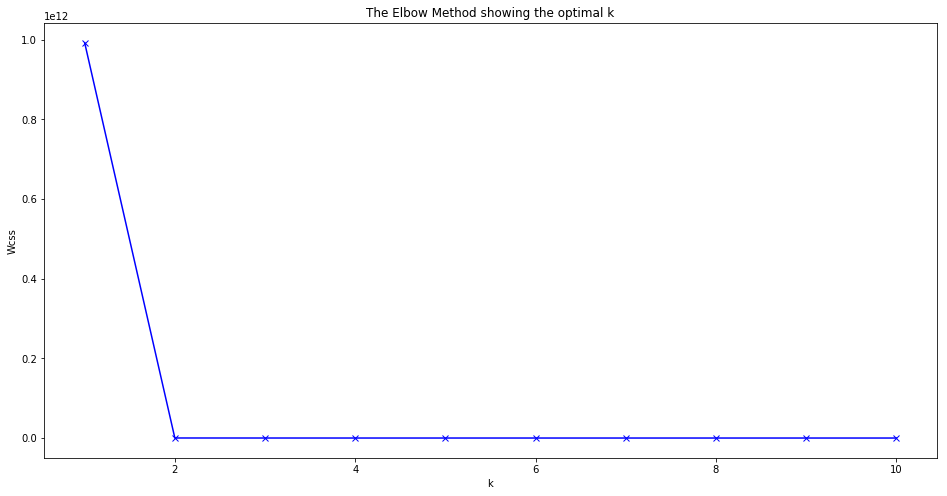

In [78]:
plt.figure(figsize=(16,8))
plt.plot(range(1,11), sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Wcss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Merging clustered with original data

In [79]:
hostel_venues_sorted.insert(0,'Cluster Labels',kmeans.labels_)
hostel_merged = df_hostel
hostel_merged = hostel_merged.join(hostel_venues_sorted.set_index('Hostel Name'), on='hostel.name')
hostel_merged.head()

,hostel.name,City,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,3,8.0,7.0,9.0,8.0,...,Sake Bar,Ramen Restaurant,Soba Restaurant,Japanese Curry Restaurant,Dessert Shop,BBQ Joint,Japanese Restaurant,Café,Chinese Restaurant,Italian Restaurant
1,&And Hostel Ueno,Tokyo,2600,8.7,7.4,2,8.0,7.5,7.5,7.5,...,Convenience Store,Ramen Restaurant,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Soba Restaurant,Donburi Restaurant,Bath House,Bed & Breakfast,Café
2,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,4,9.5,9.5,9.0,9.0,...,Convenience Store,Sake Bar,Grocery Store,Bus Stop,Bed & Breakfast,Shopping Mall,Nabe Restaurant,Outdoor Sculpture,Tempura Restaurant,Park
3,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,2,5.5,8.0,6.0,6.0,...,Convenience Store,Grocery Store,Intersection,Sake Bar,Shabu-Shabu Restaurant,Drugstore,Bed & Breakfast,Soba Restaurant,Donburi Restaurant,Bakery
4,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,4,8.7,9.7,9.3,9.1,...,Convenience Store,Japanese Restaurant,Ramen Restaurant,Café,Intersection,Sake Bar,Platform,Bed & Breakfast,Bus Stop,Canal Lock


#### Creating  map with clustered data

In [80]:
map_clusters = folium.Map(location=[35.573497306, 139.708830498], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hostel_merged['lat'], hostel_merged['lon'], hostel_merged['hostel.name'], hostel_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.Marker([35.673497306, 139.708830498], popup='National Olympic Stadium').add_to(map_clusters)       
map_clusters

### Examinging Clusters

In [84]:
c1 = hostel_merged.loc[hostel_merged['Cluster Labels'] == 0, hostel_merged.columns[[0] + list(range(2, hostel_merged.shape[1]))]]
c1.head()

,hostel.name,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,&And Hostel Ueno,2600,8.7,7.4,2,8.0,7.5,7.5,7.5,7.0,...,Convenience Store,Ramen Restaurant,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Soba Restaurant,Donburi Restaurant,Bath House,Bed & Breakfast,Café
2,&And Hostel-Asakusa North-,1500,10.5,9.4,4,9.5,9.5,9.0,9.0,9.5,...,Convenience Store,Sake Bar,Grocery Store,Bus Stop,Bed & Breakfast,Shopping Mall,Nabe Restaurant,Outdoor Sculpture,Tempura Restaurant,Park
3,1night1980hostel Tokyo,2100,9.4,7.0,2,5.5,8.0,6.0,6.0,8.5,...,Convenience Store,Grocery Store,Intersection,Sake Bar,Shabu-Shabu Restaurant,Drugstore,Bed & Breakfast,Soba Restaurant,Donburi Restaurant,Bakery
5,Ace Inn Shinjuku,2200,3,7.7,2,6.7,7.2,6.8,8.5,7.8,...,Convenience Store,Sake Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Bar,Steakhouse,Café,Chinese Restaurant,Dessert Shop
6,Aizuya Inn,2000,10.6,8.5,3,8.1,8.3,8.4,7.8,8.9,...,Convenience Store,Grocery Store,Sake Bar,Bus Stop,Intersection,Park,Bed & Breakfast,Coffee Shop,Nabe Restaurant,Outdoor Sculpture


#### Top 10 venues from cluster 1 - Red

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

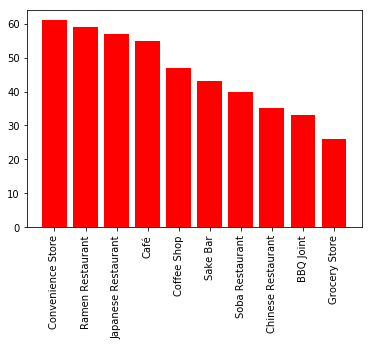

In [85]:
t1 = []
for i in range(16,25):
    t1.append(c1.iloc[:,i].value_counts())
cv1 = pd.DataFrame(t1)
cv1 = cv1.fillna(0)
sum_cv1 = cv1.sum()
sum_cv1 = sum_cv1.sort_values(ascending=False)
plt.bar(sum_cv1.index[0:10],sum_cv1[0:10],color='Red')
plt.xticks(rotation=90)

In [86]:
c2 = hostel_merged.loc[hostel_merged['Cluster Labels'] == 1, hostel_merged.columns[[0] + list(range(2, hostel_merged.shape[1]))]]
c2

,hostel.name,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,Tokyo Central Youth Hostel,1003200,4.8,8.0,3,6.0,10.0,10.0,8.0,8.0,...,Italian Restaurant,Japanese Restaurant,French Restaurant,BBQ Joint,Sake Bar,Ramen Restaurant,Yakitori Restaurant,Chinese Restaurant,Soba Restaurant,Indian Restaurant


#### Top 10 venues from cluster 2 - Purple

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

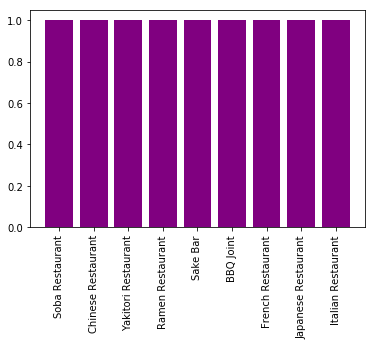

In [87]:
t2 = []
for i in range(16,25):
    t2.append(c2.iloc[:,i].value_counts())
cv2 = pd.DataFrame(t2)
cv2 = cv2.fillna(0)
sum_cv2 = cv2.sum()
sum_cv2 = sum_cv2.sort_values(ascending=False)
plt.bar(sum_cv2.index[0:10],sum_cv2[0:10],color='Purple')
plt.xticks(rotation=90)

In [88]:
c3 = hostel_merged.loc[hostel_merged['Cluster Labels'] == 2, hostel_merged.columns[[0] + list(range(2, hostel_merged.shape[1]))]]
c3.head()

,hostel.name,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,&And Hostel Akihabara,3600,7.8,8.7,3,8.0,7.0,9.0,8.0,10.0,...,Sake Bar,Ramen Restaurant,Soba Restaurant,Japanese Curry Restaurant,Dessert Shop,BBQ Joint,Japanese Restaurant,Café,Chinese Restaurant,Italian Restaurant
4,328 Hostel & Lounge,3300,16.5,9.3,4,8.7,9.7,9.3,9.1,9.3,...,Convenience Store,Japanese Restaurant,Ramen Restaurant,Café,Intersection,Sake Bar,Platform,Bed & Breakfast,Bus Stop,Canal Lock
14,Asakusa Ryokan Toukaisou,3600,9.3,8.7,3,8.0,8.4,8.4,8.8,8.8,...,Coffee Shop,BBQ Joint,Café,Ramen Restaurant,Wagashi Place,Japanese Restaurant,Yoshoku Restaurant,Unagi Restaurant,Okonomiyaki Restaurant,Bar
16,Astro Station,3500,3.8,8.4,3,7.1,9.1,8.0,9.7,7.1,...,Ramen Restaurant,Sake Bar,Japanese Restaurant,Convenience Store,Chinese Restaurant,Italian Restaurant,Beer Bar,Japanese Curry Restaurant,Tonkatsu Restaurant,Music Venue
18,Beagle Tokyo Hostel & Apartments,3800,16.1,9.0,4,8.0,10.0,9.0,8.0,9.0,...,Convenience Store,Ramen Restaurant,Japanese Restaurant,Park,Restaurant,Donburi Restaurant,Bed & Breakfast,Pub,Pool,Drugstore


#### Top 10 venues from cluster 3 - Green

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

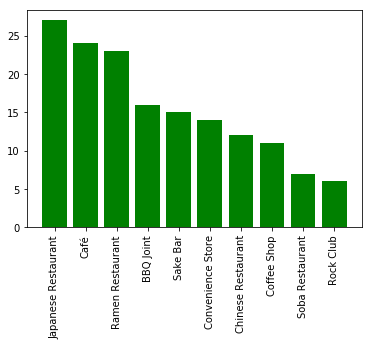

In [89]:
t3 = []
for i in range(16,25):
    t3.append(c3.iloc[:,i].value_counts())
cv3 = pd.DataFrame(t3)
cv3 = cv3.fillna(0)
sum_cv3 = cv3.sum()
sum_cv3 = sum_cv3.sort_values(ascending=False)
plt.bar(sum_cv3.index[0:10],sum_cv3[0:10],color='Green')
plt.xticks(rotation=90)

#### Average data between clusters

In [92]:
avg_clusters = pd.DataFrame()
for i in range(3):
    locals()["c"+str(i+1)].iloc[:,2] = locals()["c"+str(i+1)].iloc[:,2].astype(float)
    locals()["avg_c"+str(i+1)] = locals()["c"+str(i+1)]
    locals()["avg_c"+str(i+1)] = locals()["avg_c"+str(i+1)].drop(locals()["avg_c"+str(i+1)].columns[[0,12,13,16,17,18,19,20,21,22,23,24,25]],axis=1)
    locals()["avg_c"+str(i+1)] = locals()["avg_c"+str(i+1)].groupby('Cluster Labels').mean()  
    avg_clusters = avg_clusters.append(locals()["avg_c"+str(i+1)])
avg_clusters.round(2)

,price.from,distance.from.city.centre,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,distance.from.stadium
Cluster Labels,,,,,,,,,,,,
0,2275.58,8.96,8.78,3.40,8.22,8.98,8.54,8.57,9.14,9.16,8.87,16.43
1,1003200.00,4.80,8.00,3.00,6.00,10.00,10.00,8.00,8.00,8.00,6.00,14.50
2,3993.10,6.68,8.89,3.48,8.39,9.25,8.77,8.74,8.93,9.31,8.85,12.82


## Results and Discussion <a name="results"></a>

Our analysis shows that from the data that were available to us we could divide hostels in three clusters and that:
* The main factor used to divide the clusters was the hostels price
* The second (Purple) cluster can be considered an outliers because of the huge price difference comparing to the others, making it a cluster of 1 hostel only
* The best cost-benefit hostels are in the Third (Green) cluster since they have intermediate price, higher hatings and score and tend to be closer to the center of the city as well as to the Olympic Stadium

## Conclusion <a name="conclusion"></a>

Purpose of this project was to aid our StakeHolders to find hostels that could best fill their needs based on a different number of features when visiting Tokyo for the Olympics. To do that, we gathered data from different datasets and the FourSquare API and then created clusters based on their attributes and compared them, narrowing the StakeHolder choices in the trip planning process.